# Model Evaluation

In [1]:
import torch
import os
import utils

import warnings
warnings.filterwarnings('ignore')

## Prepare Test Set

In [2]:
# path of img data
pth_train = 'Data/Training_Patch'
pth_valid = 'Data/Validation_Patch'
pth_test = 'Data/ISIC2017/ISIC-2017_Test_Data'


ann_train = utils.Annotation('Data/ISIC2017/ISIC-2017_Training_Aug_Part3_GroundTruth.csv')
ann_valid = utils.Annotation('Data/ISIC2017/ISIC-2017_Validation_Part3_GroundTruth.csv')
ann_test = utils.Annotation('Data/ISIC2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

In [3]:
from torchvision import transforms
from torch.utils import data

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
                                ])

# augmentation transform
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomAffine(10, scale=(0.9, 1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

In [4]:
from PIL import Image
import random


class TestData(data.Dataset):
    def __init__(self, annotations, img_dir: str, transform=None, target_transform=None):
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.scales = [1/5, 2/5, 3/5, 4/5]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx: int):
        idx_sample = idx
        img_path = os.path.join(self.img_dir, self.img_labels.image_id[idx_sample] + '.jpg')
        image = Image.open(img_path)
        image = self.rescale_crop(image)
        target = self.img_labels['label'].iloc[idx_sample]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target

    def rescale_crop(self, image):
        scale = self.scales[random.randint(0, 3)]
        w, h = image.size
        if scale > 2/3:
            trans = transforms.RandomCrop((int(h * scale), int(w * scale)), pad_if_needed=True, padding_mode='edge')
        else:
            trans = transforms.Compose([
            transforms.CenterCrop((int(h - h * (1 - scale)**2), int(w - w * (1 - scale)**2))),
            transforms.RandomCrop((int(h * scale), int(w * scale)), pad_if_needed=True, padding_mode='edge'),
        ])

        img = trans(image)

        return img

In [5]:
# create test dataset
test_data = TestData(ann_test.df, pth_test, transform=transform)
test_loader = data.DataLoader(test_data, batch_size=32, shuffle=False)

In [6]:
# create train dataset
train_data = utils.Data(ann_train.df, pth_train, 60, transform=transform_train)
train_loader = data.DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

# create validation dataset
valid_data = utils.Data(ann_valid.df, pth_valid, 1, transform=transform)
valid_loader = data.DataLoader(valid_data, batch_size=32, shuffle=False)

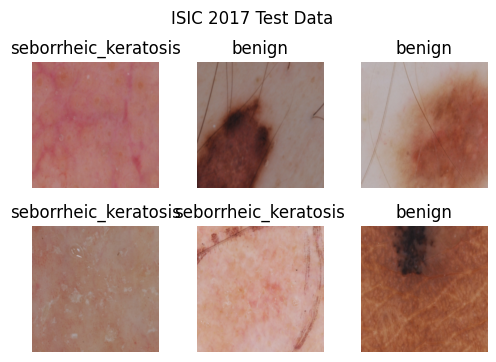

In [7]:
x, y = next(iter(test_loader))
labels = ann_test.to_names(y)

utils.show_samples(x, labels, 2, 3, "ISIC 2017 Test Data")

## Load Model

In [8]:
# GPU setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
# import nets
# model = nets.arlnet50(num_classes=3)
# model = utils.load_state_dict(model, device, name='state_dict.pth')

model = utils.load_model(device, name='arl50.pkl')

Load arl50.pkl on cuda successfully.


## Evaluation
In the test stage, we used the same patch extraction method to randomly crop nine patches from each test image, fed them to the trained network, and averaged the obtained scores as the predicted score of the image.

### Quantitative

In [10]:
import torch.nn as nn
import numpy as np

@torch.no_grad()
def get_probs(model, data_loader, device):
    """ make predictions on datasets

    Returns:
        lists of labels and predictions
    """
    model.eval()
    label = []
    prob = [[1 for _ in range(3)]]
    soft = nn.Softmax(dim=-1)

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        z = model(x)
        p = soft(z)
        # _, yhat = torch.max(z.data, 1)
        label = np.concatenate((label, y.to('cpu')), axis=-1)
        prob = np.concatenate((prob, p.to('cpu')), axis=-2)
    prob = prob[1::]

    return label, prob

label, probs = get_probs(model, test_loader, device)
probs = [probs]

for _ in range(8):
    _, prob = get_probs(model, test_loader, device)
    probs.append(prob)

prob = np.mean(probs, axis=0)
pred = np.argmax(prob, 1)

                      precision    recall  f1-score   support

            melanoma       0.68      0.47      0.56       117
seborrheic_keratosis       0.79      0.72      0.76        90
              benign       0.82      0.91      0.86       393

            accuracy                           0.80       600
           macro avg       0.76      0.70      0.72       600
        weighted avg       0.79      0.80      0.79       600



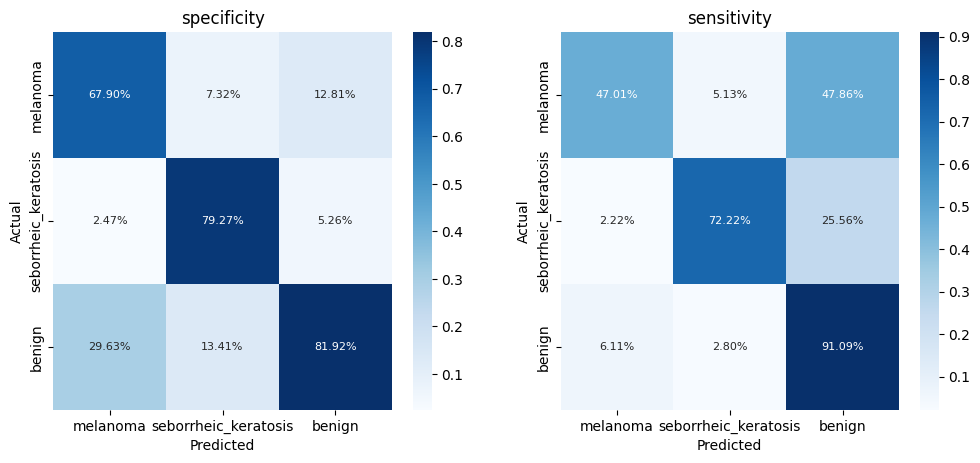

In [11]:
from sklearn import metrics

report = metrics.classification_report(label, pred, target_names=ann_test.categories)
print(report)

cf_matrix = utils.get_confusion(label, pred, ann_test.categories)
utils.draw_confusion(cf_matrix)

## Qualitative

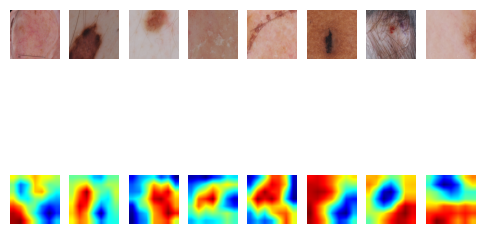

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

feature_map = None
def hook(model, inputs, outputs):
    global feature_map
    feature_map = outputs.cpu().detach()

model.layer4.register_forward_hook(hook)

weights = model.fc_.weight.cpu().detach()

for x, y in test_loader:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    fig, axes = plt.subplots(2, 8, facecolor='#ffffff', dpi=100)
    axes = [ax for ax in axes.flat]
    for i in range(8):
        img = x[i].detach().numpy().transpose((1, 2, 0))
        img = img * std + mean
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis("off")
    
    model.eval()
    x = x.to(device)
    class_idx = y.detach()
    z = model(x)
    
    cams = utils.CAM(feature_map, weights, class_idx)
    for i in range(8, 16):
        utils.draw_cam(axes[i], cams[i])
    plt.show()

    break